# Train on MNIST - Example

This notebook is used to implement the training of a neural network for the ["MNIST ("Modified National Institute of Standards and Technology")](http://yann.lecun.com/exdb/mnist/index.html) dataset. <br> To train our network, we use [PyTorch](https://pytorch.org/). <br> PyTorch implements a suit that allows you to implement a neural network and the backpropagation algorithm easily. <br>
For aximum performance, we suggest to switch the computing resources to `GPU`. You can do that by clicking on the arrow on top-right of the screen, then `change runtype time`, and finally `T4 GPU`.

The next celll will install [torchvision](https://pytorch.org/vision/stable/index.html), which is needed to download and manage the MNIST dataset.

In [1]:
!uv pip install torch torchvision

Using Python 3.12.8 environment at: C:\Users\jesse\Documents\TU Delft\MSE git\img_classification\.venv
Audited 2 packages in 6ms


## 1. - Imports

Enabling autoreload of different packages.

In [2]:
%load_ext autoreload
%autoreload 2

### 1.1 Assignment imports

In [3]:
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

## 2. - Datasets

### 2.1 - Loading MNIST dataset

We now download load the dataset into 2 splits (`Train` and `Test`).

In [4]:
# Train split
train_MNIST = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ]))
# Test split
test_MNIST = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.1MB/s]


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:05<00:00, 312kB/s]


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



### 3.2 - Splitting Train into Train and Cross Validation

As discussed in the lecture slides, to train the model correctly we split the entire MNIST dataset into three splits to train our model:
* **Train** : 71.43%
* **Cross-Validation** : 14.23%
* **Test**: 14.23% <br>

You can also change the train/cross-validation percentage by changing the value of `cv_percentage` from its default value (`0.1666540669186616`). <br> <br>
It is also possible to test a wrong splitting that leads to **overfitting**. Ovefitting occurs when the model fits the training split too tightly that is not able to generalize on the validation and test splits. To virtually creating overfitting, set the flag `test_overfitting` to `True`. If you do that, we will split the dataset so that all the images containing a `8` or a `9` will be not included in the training but in the cross-validation. In this condition, the model will be able to learn the data in the training set quite well. However, it will be not able to classify correctly the images containing `8` or a `9` since it did not see them during training. This is similar to the experience that  students might face when the explanations given in class do not cover topics requested in their homework. Overfitting is not only due to mistmatches between the data distributions of training and other splits. Later you will find a more detailed explanation about this problem.  
<br>
If you want to experiment **underfitting**, set `test_overfitting` to `False` and  increase the value of `cv_precentage` from its default value to `0.95`. This will significantly increase the size of the **cross validation split** at detriment of the **train split**, which will be strongly reduced.  In this condition, the model has so few data available for training that is not able to learn at all. <br> This is similar to the condition that students face when the explanation provided by tutor is so poor that they are not even able to reproduce the exercises done during the lesson. <br> I hope this is not the case for you :).

In [5]:
# CV percentage (ignored if test_overfitting == True)
cv_percentage=0.1666540669186616

We are now randomly splitting `train_MNIST` into `train_MNIST` and `cv_MNIST` with the requested percentages.

In [6]:
# Stacking tuples into a single list
train_MNIST_list = []
train_MNIST_list = [train_MNIST_list + list(x) for x in train_MNIST]

# Creating random splits with the requested percentage
train_idx, valid_idx = train_test_split(list(range(60000)), test_size=(cv_percentage))
# Creating Valid
cv_MNIST = [train_MNIST_list[x] for x in valid_idx]
# Creating Train
train_MNIST = [train_MNIST_list[x] for x in train_idx]

## 3 - Creating a model

We now create a custom **Convolutional Neural Network (CNN)**. The network is created and designed **from scratch** for the sake of providing an example. <br> However, in real life, this might not be the best idea. [Here](https://paperswithcode.com/sota/image-classification-on-imagenet) you can see the benchmark among different models on the [ImageNet](https://www.image-net.org/), a very complex benchmark dataset for image classification. <br>
In general, it is also possible to start from a **pretrained model**, i.e., a model that was already trained on another dataset (typically, `ImageNet`) to leverage preliminary `knowledge` that a network acquired on another dataset, which can be particularly useful when few training examples are available. <br> In our example, the network is custom and not pretrained.

In [7]:
class CNNNet(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(CNNNet, self).__init__()
        # Convolutional layer (1 input channel, 25 output-channels, 5x5 kernels)
        self.conv1 = nn.Conv2d(1, 25, kernel_size=5)
        # Convolutional layer (25 input channel, 100 output-channels, 5x5 k.)
        self.conv2 = nn.Conv2d(25, 100, kernel_size=5)
        # Dropout - This layer is used to remove unnecessary neurons.
        self.conv2_drop = nn.Dropout2d()
        # Convolutional layer (100 input channel, 25 output-channels, 3x3 k.)
        self.conv3 = nn.Conv2d(100, 25, kernel_size=3)
        # Average pooling - Spatial average of the pixels
        self.avg_pool = torch.nn.AvgPool2d(2)
        # Fully connected layer
        self.fc2 = nn.Linear(25, 10)

    # Describes how the network behave
    def forward(self, x):

        y = self.conv1(x)
        # Pooling layers - selects the max between 2 neurons
        y = F.max_pool2d(y,2)
        # Relu - Activation function
        y = F.relu(y)
        # Convolutional layer (10 input channel, 50 output-channels, 5x5 k.)
        y = self.conv2(y)
        # Dropout
        y = self.conv2_drop(y)
        # Pooling layers - selects the max between 2 neurons
        y = F.max_pool2d(y,2)
        # Relu - Activation function
        y = F.relu(y)
        # Convolutional layer
        y = self.conv3(y)
        # Relu - Activation function
        y = F.relu(y)
        # Convolutional layer
        y = self.avg_pool(y)
        # Fully connected layer
        # Squeeze is needed because fc2 requires
        # a 2D tensor.
        y = self.fc2(y.squeeze(-1).squeeze(-1))
        # Applying Softmax
        p_c = F.log_softmax(y, dim=1)
        return p_c

We create an instance of our network.

In [8]:
model = CNNNet()

## 4 - Preparing for training - Setting Hyperparameters

Weights and biases in a model are called **parameters**, which are actually learned by the model during training. However, there are other tunable variables such as the number of neurons in a layer, the size of a kernel, and others that are not directly learned by the network but whose values can affect training. Such variables are called **hyperparameters**. Some of the hyperparameters, such as the number of epochs and learning rate, will be now explained and set.

### 4.1 - Setting Cross-entropy loss.

To train the model, we use [Categorical Cross-entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) loss, as specified by the next cell.

In [9]:
loss = nn.CrossEntropyLoss()

4.2 - Selecting number of epochs and batch size.

We are going to select:
* `number of epochs`: number of epochs specify how many times the entire dataset is seen by the model during training. Increasing the number of epochs typically leads the model to learn better the training dataset (i.e., to lower loss values in the training set). However, this is not necessarily a positive thing given the risk of **overfitting** the dataset. **Try to play with the number of epochs to see the impact in training.**

* `batch size`: In the lesson slides, we have calculated the loss over the entire dataset (whose number is called `N`). When the input data are images, it is typically impossible to provide the entire dataset as input to the model in a single pass because of GPU/CPU memory limitations. Therefore, each epoch is therefore divided into a certain number of `iterations`, during which the loss function is calculated on a reduced number of samples (`batch`). The `batch size` is, of course, the size of batches. Typically, the `batch size` is a power of 2 to allow for better computational performances (better optimization to computing hardware). <br> The choice on the `batch size` typically influences both the training time and the model accuracy.  **Higher batch sizes** allow for:
    *  **higher computational performances**: because of the higher parallization (as far as they fit into your hardware memory and your hardware can profit of it).
    *  **lower convergence** (so, not necessarily a faster training in the end):  high batch size means lower number of batches and, therefore, lower number of updates.
    *  **more robust toward noise and fluctuations**: because the loss is evaluated on a higher number of samples, so the averaging effect is stronger.
    *  **higher overfitting**: the noise due to batching acts as a regularization agent during the training reducing overfitting. Such noise is reduced because of the stronger averaging effect, diminishing the regularization effect.

In [10]:
# Number of epochs
n_epochs = 10
# Batch size
batch_size=32

### 4.2 - Create dataloaders.

To break your dataset into `batch` of size `batch_size`, PyTorch provides a construct called [data loader](https://www.educative.io/answers/what-is-pytorch-dataloader).<br> As previously mentioned, this is useful to ensure that your dataset will fit into your memory and to create a "stochastic" implementation of gradient descent. <br>

In [11]:
# Train loader
train_loader = DataLoader(train_MNIST, batch_size=batch_size, pin_memory=False, shuffle=True)
# Cross validation data loader
valid_loader = DataLoader(cv_MNIST, batch_size=batch_size, pin_memory=False, shuffle=True)
# Test data loader
test_loader = DataLoader(test_MNIST, batch_size=batch_size, pin_memory=False, shuffle=True)

### 4.3 -  Selecting Training optimizer

To train the model we are now selecting [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer, which means `Stochastic Gradient Descent`. <br> You can think of optimizers as rules that specify how to update parameters. Different optimers lead to different weights for the same model, data and loss function. There is not a specific rule on how to select an optimizer. You can find more information on optimizers [here](https://pytorch.org/docs/stable/optim.html) is popular for its performance/memory-efficiency trade-offs. <br> The **learning rate** (`lr`) is a scale-factor hyperparameter that determines the step-size in updating your model parameters. During training, you want to minimize the loss function, which means reaching the minimum with a fixed step size. The **learning rate** is the size of your step, If your step is too big, you might end-up missing the minimum and jumping over the minimum. However, if your step is too small, your training time will be very long and the risk to get stuck in local minima is very high.

In [12]:
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)

## 5 - Train

In the next cell, we start the training of our model.
During the training we log the `train_loss` and the `evaluation_loss` to be able to monitor the outcome of training after training. <br>  Training of deep neural networks is typically  a slow processes. Because of that, it is possible to skip the training process by loading the trained model and the values of the loss from files to save you some time. To this aim, set the flag `skip_train` to `True` in the next cell. <br> However, it could be useful to you to try change some of the parameters (e.g., `cv_percentage`, `nr_of_epochs`) to see their impact on training results.

In [13]:
skip_training=False

If you have selected `skip_training=False`, training will be started. In addition to the loss values, we also print the `accuracy` on `train` and `cross_validation`. You should see the **losses decreasing** and **accuracies increasing** (as a trend) over the various epochs. <br> Please, notice that we are not trying to prevent overfitting in any way (except for Dropout layers). <br>

In [ ]:
# Training performed
if not(skip_training):

  # Placeholder for training loss
  train_loss_list=[]
  # Placeholder for validation loss
  cv_loss_list=[]

  # If GPU is available and selected, model is moved to GPU.
  if torch.cuda.is_available():
    model=model.cuda()

  # Start training - looping over n_epochs.
  for epoch in tqdm(range(n_epochs), desc="Epochs"):
      # Setting up the model to perform training.
      model.train()

      # Number of correct predictions for train split
      train_correct = 0
      # Number of total predictions for train split
      train_total = 0
      # Perform mini-batch training, i.e., splitting training into a certain number of batches.
      for x_train_batch, y_train_batch in tqdm(train_loader, desc='Training - Iterations:'):
          # If GPU is available and selected, data are moved to GPU.
          if torch.cuda.is_available():
            # Move to GPU
            x_train_batch=x_train_batch.cuda()
            y_train_batch=y_train_batch.cuda()

          # Setting the gradient to zero.
          optimizer.zero_grad()
          # Calculating the predictions on the batch.
          y_pred_train = model(x_train_batch)
          # Calculating the loss between Y_pred and the y_train_batch (targets).
          train_loss = loss(y_pred_train, y_train_batch)
          # Back-propagting the loss, i.e., calculating the weight increments in the different layers.
          train_loss.backward()
          # Updating weights by using SGD optimizer.
          optimizer.step()
          # Extracting predicted class.
          y_train_predicted_class = torch.max(y_pred_train, 1)[1]
          # Updating total and number of corrected patches
          train_correct += (y_train_predicted_class == y_train_batch).sum().item()
          train_total += y_train_batch.size(0)

      # Calculating training accuracy
      train_accuracy = train_correct/train_total * 100

      # Append training loss values at the end of an epoch
      train_loss_list.append(train_loss)


      print(f'Evaluating model at epoch: {epoch}.')

      # Setting up the model to perform the inference (some layers in the model behave differently during the training and inference)
      model.eval()

      # Number of correct predictions for cross validation split
      cv_correct = 0
      # Number of total predictions for cross validation split
      cv_total = 0

      # Evaluating model on the cross-validation split. Since we are not training, we do not need to calculate gradients.
      with torch.no_grad():
          # Splitting cross-validation into batches.
          for x_cv_batch, y_cv_batch in tqdm(valid_loader, desc='Evaluation - Iteration:'):
              # Moving batches to the GPU if available
              if torch.cuda.is_available():
                  x_cv_batch=x_cv_batch.cuda()
                  y_cv_batch=y_cv_batch.cuda()

              # Performing evaluation on the cross-valiation split.
              y_cv_pred = model(x_cv_batch)
              # Extracting loss on the cross-valiation split.
              cv_loss = loss(y_cv_pred, y_cv_batch)
              # Extracting predicted class.
              y_cv_predicted_class =  torch.max(y_cv_pred, 1)[1]
              # Updating total and number of corrected patches
              cv_total += y_cv_batch.size(0)
              cv_correct += (y_cv_predicted_class == y_cv_batch).sum().item()
          # Calculating the evaluation accuracy
          cv_accuracy = cv_correct/cv_total * 100

          # Append validation loss values at the end
          cv_loss_list.append(cv_loss)

      # Print information
      print(f"\033[1mEpoch\033[1m: {str(epoch)}")
      print(f"\033[1mTrain loss\033[1m: {str(float(train_loss))}.")
      print(f"\033[1mTrain accuracy[%]\033[1m: {str(train_accuracy)}.")
      print(f"\033[1mCross-validation loss\033[1m: {str(float(cv_loss))}.")
      print(f"\033[1mCross-validation accuracy[%]\033[1m: {str(cv_accuracy)}.")

  # Saving best model
  torch.save(model.state_dict(), "trained_model.pth")
  print("Train finished.")
else:
  print("Skipping training...")
  try:
    # Load loss values from file
    with open('losses.pkl', "rb") as f:  # Python 3: open(..., 'rb')
      train_loss_list, cv_loss_list = pickle.load(f)
  except:
    raise ValueError("It seems you have missed some files from Brightspace. One or both the losses values were missing. Please, upload them and execute this cell again or try to do the training.")
  try:
    model.load_state_dict(torch.load("trained_model.pth"))
  except:
    raise ValueError("It seems you are using a different model from the default one (strong) or the ""trained_model.pth"" file is missing.")

## 6 - Monitor training results

### 6.1 - Plotting loss values over training

The next cell will show the training results. If you used the model with defaults values of parameters and `test_overfitting=False`, training should have gone well. In this case, both the **train** and **cross-validation** losses should have sufficiently decreased during training. <br> If you had experimented **overfitting**, only the loss function on the training set should have decreased much more than the one into cross validation split. <br>
In case of **underfitting** both the loss have decreased very few.

Text(0, 0.5, 'Loss')

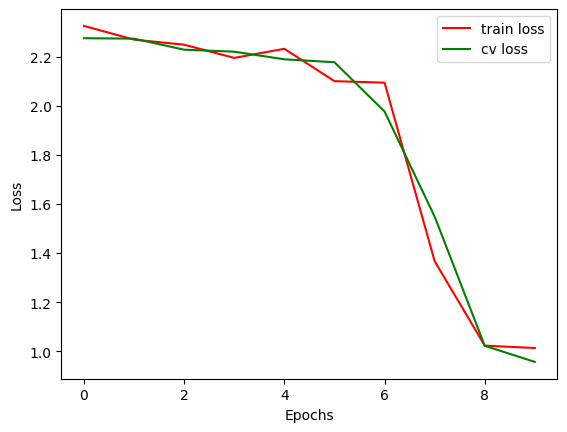

In [15]:
# Preparation for plot. Moving losses from GPU to CPU (required by matplotlib) and converting them to list.
if torch.is_tensor(train_loss_list[0]):
   train_loss_list=[float(x.detach().cpu()) for x in train_loss_list]

if torch.is_tensor(cv_loss_list[0]):
   cv_loss_list=[float(x.detach().cpu()) for x in cv_loss_list]
plt.plot(range(len(train_loss_list)), train_loss_list,'r')
plt.plot(range(len(cv_loss_list)), cv_loss_list, 'g')
plt.legend(["train loss", "cv loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [16]:
with open('losses.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([train_loss_list, cv_loss_list], f)

## 6.2 - Measuring accuracy on the test split

The next cell will measure the accuracy that the trained model achieves on the test split.

In [17]:
# Set model to evaluation model (some layers, as dropout will change their behaviour)
model.eval()

# Number of correct predictions for test split
test_correct = 0
# Number of total predictions for test split
test_total = 0

# Prediction placeholders
predictions=[]

# Target placeholders
targets=[]

# Images placeholders
images=[]

# Moving model to GPU if CUDA is available.
if torch.cuda.is_available():
    model=model.cuda()

# Evaluating model on the test split. Since we are not training, we do not need to calculate gradients.
with torch.no_grad():
    # Splitting cross-validation into batches.
    for x_test_batch, y_test_batch in tqdm(test_loader, desc='Test - Iteration:'):
        # Moving batches to GPU if CUDA is available.
        if torch.cuda.is_available():
            x_test_batch=x_test_batch.cuda()
            y_test_batch=y_test_batch.cuda()

        # Performing evaluation on the test split.
        y_test_pred = model(x_test_batch)
        # Extracting predicted class.
        y_test_predicted_class =  torch.max(y_test_pred, 1)[1]
        # Updating total and number of corrected patches
        test_total += y_test_batch.size(0)
        test_correct += (y_test_predicted_class == y_test_batch).sum().item()
        # Stacking predictions, targets, and images.
        predictions+=list(y_test_predicted_class)
        targets+=list(y_test_batch)
        images+=list(x_test_batch)
    # Calculating the evaluation accuracy
    test_accuracy = test_correct/test_total * 100

print('\033[1mTest accuracy[%]\033[1m: ' +str(float(test_accuracy)))

# Moving predictions, images and targets to CPU
predictions=[x.detach().cpu().numpy() for x in predictions]
targets=[x.detach().cpu().numpy() for x in targets]
images=[x.detach().cpu().numpy() for x in images]


Test - Iteration:: 100%|██████████| 313/313 [00:01<00:00, 185.03it/s]


Test accuracy[%]: 80.4


## 6.3 - Show predictions on random images

The next cell will take randome examples from the test split and showcases the predicted class (**predicted**) versus the (**expected**) class. <br> This is done through the `plot_random_samples` included in the `utils.py` file.
If you have set `test_overfitting` to `True`, you will see the model will be in general capable to predict correctly all the classes but `8` and `9`.

In [18]:
import matplotlib.pyplot as plt
def plot_samples(samples, targets, predictions):
  fig, axes = plt.subplots(1, 5, figsize=(10, 2))
  for i, ax in enumerate(axes):
    sample = samples[i].reshape(28, 28) # Reshape to (28, 28)
    ax.imshow(sample, cmap='gray')
    ax.set_title(f'True: {targets[i]} | Pred: {predictions[i]}')
    ax.axis('off')
    plt.tight_layout()

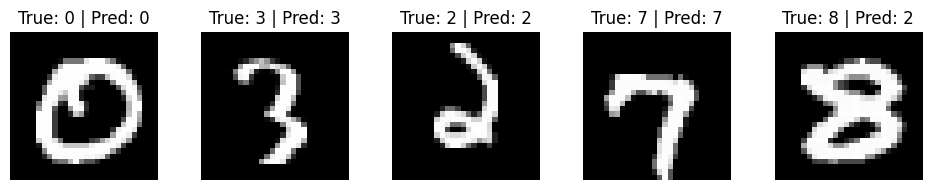

In [19]:
plot_samples(images, targets, predictions)